X-ray Transform Comparison in 3D
================================

This example shows how to define a SCICO native 3D X-ray transform using
ASTRA toolbox conventions and vice versa.

In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import scico.linop.xray
import scico.linop.xray.astra as astra
from scico import plot
from scico.examples import create_block_phantom
from scico.linop import Parallel3dProjector, XRayTransform
from scico.util import Timer
from scipy.spatial.transform import Rotation
plot.config_notebook_plotting()

Create a ground truth image and set detector dimensions.

In [2]:
N = 64
# use rectangular volume to check whether it is handled correctly
in_shape = (N + 1, N + 2, N + 3)
x = create_block_phantom(in_shape)
x = jnp.array(x)

# use rectangular detector to check whether it is handled correctly
out_shape = (N, N + 1)

Set up SCICO projection.

In [3]:
num_angles = 3

# make projection matrix: form a rotation matrix and chop off the last row
rot_X = 90.0 - 16.0
rot_Y = np.random.rand(num_angles) * 180
P = jnp.stack([Rotation.from_euler("XY", [rot_X, y], degrees=True).as_matrix() for y in rot_Y])
P = P[:, :2, :]

# add translation
x0 = jnp.array(in_shape) / 2
t = -jnp.tensordot(P, x0, axes=[2, 0]) + jnp.array(out_shape) / 2
P = jnp.concatenate((P, t[..., np.newaxis]), axis=2)

Specify geometry using SCICO conventions and project.

In [4]:
num_repeats = 3

timer_scico = Timer()
with ContextTimer(timer_scico, "init"):
    H_scico = XRayTransform(Parallel3dProjector(in_shape, P, out_shape))

with ContextTimer(timer_scico, "first_fwd"):
    y_scico = H_scico @ x
    jax.block_until_ready(y_scico)

with ContextTimer(timer_scico, "first_fwd"):
    y_scico = H_scico @ x

with ContextTimer(timer_scico, "avg_fwd"):
    for _ in range(num_repeats):
        y_scico = H_scico @ x
        jax.block_until_ready(y_scico)
timer_scico.td["avg_fwd"] /= num_repeats

with ContextTimer(timer_scico, "first_back"):
    HTy_scico = H_scico.T @ y_scico

with ContextTimer(timer_scico, "avg_back"):
    for _ in range(num_repeats):
        HTy_scico = H_scico.T @ y_scico
        jax.block_until_ready(HTy_scico)
timer_scico.td["avg_back"] /= num_repeats

Convert SCICO geometry to ASTRA and project.

In [5]:
P_to_astra_vectors = scico.linop.xray.P_to_vectors(in_shape, P, out_shape)

timer_astra = Timer()
with ContextTimer(timer_astra, "init"):
    H_astra_from_scico = astra.XRayTransform3D(
        input_shape=in_shape, det_count=out_shape, vectors=P_to_astra_vectors
    )

with ContextTimer(timer_astra, "first_fwd"):
    y_astra_from_scico = H_astra_from_scico @ x
    jax.block_until_ready(y_scico)

with ContextTimer(timer_astra, "first_fwd"):
    y_astra_from_scico = H_astra_from_scico @ x

with ContextTimer(timer_astra, "avg_fwd"):
    for _ in range(num_repeats):
        y_astra_from_scico = H_astra_from_scico @ x
        jax.block_until_ready(y_astra_from_scico)
timer_astra.td["avg_fwd"] /= num_repeats

with ContextTimer(timer_astra, "first_back"):
    HTy_astra_from_scico = H_astra_from_scico.T @ y_astra_from_scico

with ContextTimer(timer_astra, "avg_back"):
    for _ in range(num_repeats):
        HTy_astra_from_scico = H_astra_from_scico.T @ y_astra_from_scico
        jax.block_until_ready(HTy_astra_from_scico)
timer_astra.td["avg_back"] /= num_repeats

Specify geometry with ASTRA conventions and project.

In [6]:
angles = np.random.rand(num_angles) * 180  # random projection angles
det_spacing = [1.0, 1.0]
vectors = astra.angle_to_vector(det_spacing, angles)

H_astra = astra.XRayTransform3D(input_shape=in_shape, det_count=out_shape, vectors=vectors)

y_astra = H_astra @ x
HTy_astra = H_astra.T @ y_astra

Convert ASTRA geometry to SCICO and project.

In [7]:
P_from_astra = scico.linop.xray.astra_to_scico(H_astra.vol_geom, H_astra.proj_geom)
H_scico_from_astra = XRayTransform(Parallel3dProjector(in_shape, P_from_astra, out_shape))

y_scico_from_astra = H_scico_from_astra @ x
HTy_scico_from_astra = H_scico_from_astra.T @ y_scico_from_astra

Print timing results.

In [8]:
print(f"init         astra    {timer_astra.td['init']:.2e} s")
print(f"init         scico    {timer_scico.td['init']:.2e} s")
print("")
for tstr in ("first", "avg"):
    for dstr in ("fwd", "back"):
        for timer, pstr in zip((timer_astra, timer_scico), ("astra", "scico")):
            print(f"{tstr:5s}  {dstr:4s}  {pstr}    {timer.td[tstr + '_' + dstr]:.2e} s")
        print()

init         astra    1.26e-04 s
init         scico    7.98e-01 s

first  fwd   astra    9.64e-02 s
first  fwd   scico    6.79e-04 s

first  back  astra    4.93e-02 s
first  back  scico    4.94e-01 s

avg    fwd   astra    4.73e-02 s
avg    fwd   scico    6.36e-04 s

avg    back  astra    4.77e-02 s
avg    back  scico    8.34e-04 s



Show projections.

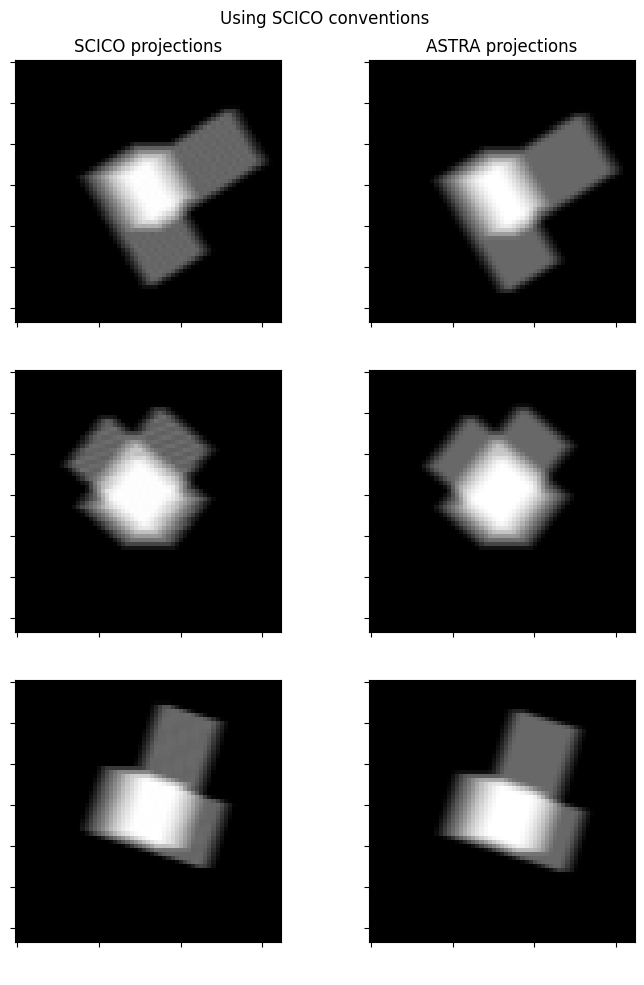

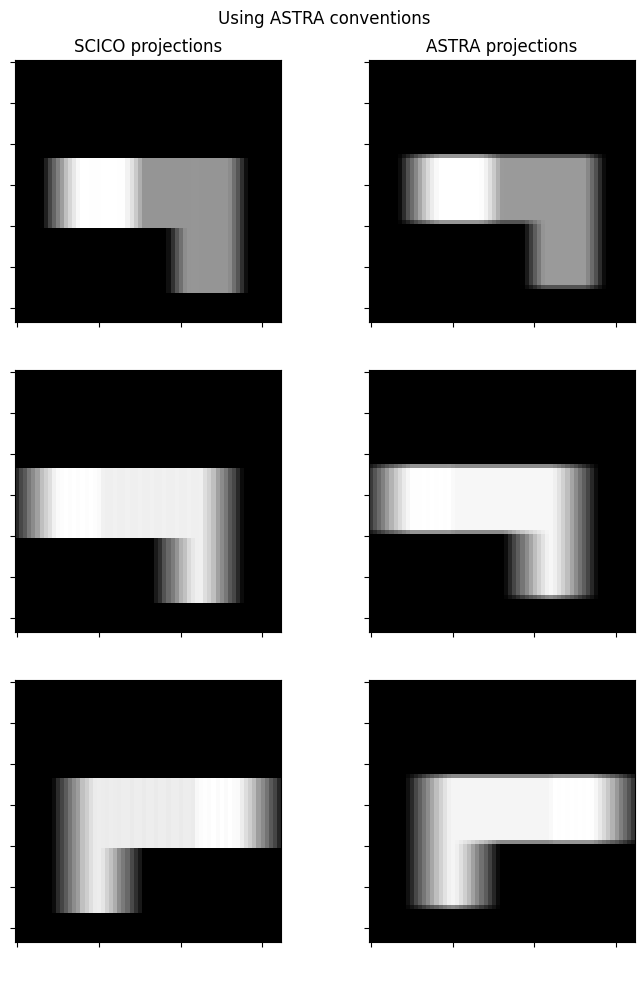

In [9]:
fig, ax = plot.subplots(nrows=3, ncols=2, figsize=(8, 10))
plot.imview(y_scico[0], title="SCICO projections", cbar=None, fig=fig, ax=ax[0, 0])
plot.imview(y_scico[1], cbar=None, fig=fig, ax=ax[1, 0])
plot.imview(y_scico[2], cbar=None, fig=fig, ax=ax[2, 0])
plot.imview(y_astra_from_scico[:, 0], title="ASTRA projections", cbar=None, fig=fig, ax=ax[0, 1])
plot.imview(y_astra_from_scico[:, 1], cbar=None, fig=fig, ax=ax[1, 1])
plot.imview(y_astra_from_scico[:, 2], cbar=None, fig=fig, ax=ax[2, 1])
fig.suptitle("Using SCICO conventions")
fig.tight_layout()
fig.show()

fig, ax = plot.subplots(nrows=3, ncols=2, figsize=(8, 10))
plot.imview(y_scico_from_astra[0], title="SCICO projections", cbar=None, fig=fig, ax=ax[0, 0])
plot.imview(y_scico_from_astra[1], cbar=None, fig=fig, ax=ax[1, 0])
plot.imview(y_scico_from_astra[2], cbar=None, fig=fig, ax=ax[2, 0])
plot.imview(y_astra[:, 0], title="ASTRA projections", cbar=None, fig=fig, ax=ax[0, 1])
plot.imview(y_astra[:, 1], cbar=None, fig=fig, ax=ax[1, 1])
plot.imview(y_astra[:, 2], cbar=None, fig=fig, ax=ax[2, 1])
fig.suptitle("Using ASTRA conventions")
fig.tight_layout()
fig.show()

Show back projections.

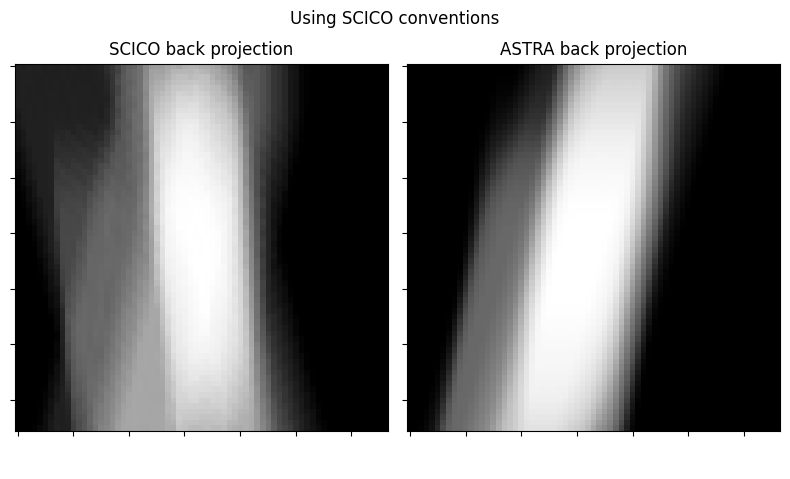

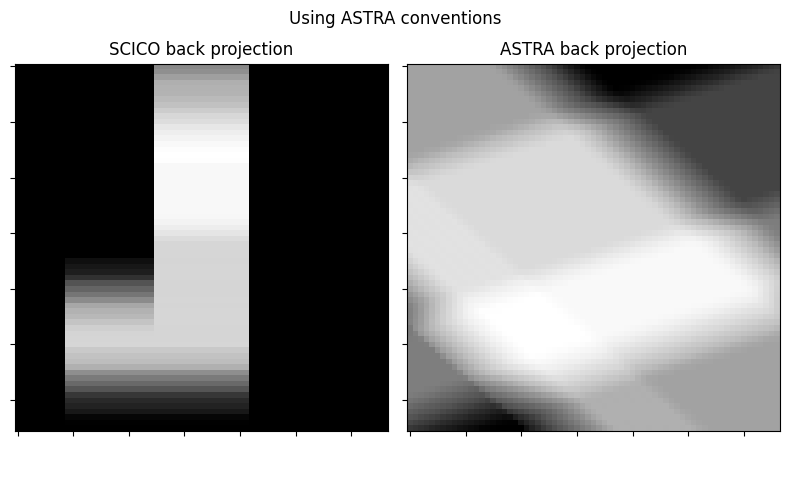

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(8, 5))
plot.imview(HTy_scico[N // 2], title="SCICO back projection", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    HTy_astra_from_scico[N // 2], title="ASTRA back projection", cbar=None, fig=fig, ax=ax[1]
)
fig.suptitle("Using SCICO conventions")
fig.tight_layout()
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(8, 5))
plot.imview(
    HTy_scico_from_astra[N // 2], title="SCICO back projection", cbar=None, fig=fig, ax=ax[0]
)
plot.imview(HTy_astra[N // 2], title="ASTRA back projection", cbar=None, fig=fig, ax=ax[1])
fig.suptitle("Using ASTRA conventions")
fig.tight_layout()
fig.show()